In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [4]:
#Lignes de début et fin de collecte des données dans les fichiers.txt
indice_deb = 2305
indice_fin = 2445

def extraction_valeurs(filename):
    with open(filename, "r") as file:
        photons = []
        wavelengths = []
        reading = False
        for i, line in enumerate(file):
            if i==indice_deb:
                reading = True
            elif i==indice_fin:
                reading = False
            if reading:
                values = line.split()
                if len(values) == 2:  # Ensure the line has exactly 2 columns
                    Lambda = values[0].replace(",", ".")
                    valeur = values[1].replace(",",".")
                    wavelengths.append(float(Lambda))
                    photons.append(float(valeur))
    return(np.array(wavelengths), np.array(photons))

In [7]:
noir = "Noir_aveclumière_2711.txt"

bleu = "bleu_66deg_100mW_3s_2avg_2boxcar.txt"

#caractéristiques du noir et du bleu, obtenu en plaçant la lame lambda/2 à 90° par rapport à 21°

wavelengths, photons = extraction_valeurs(noir)

valeurs_noir = pd.Series(photons)

caract_noir = valeurs_noir.describe()

avg_noir = caract_noir["mean"]

wavelengths_bleu, photons_bleu = extraction_valeurs(bleu)

valeurs_bleu = pd.Series(photons)

caract_bleu = valeurs_noir.describe()

avg_bleu = caract_bleu["mean"]

In [8]:
#Fonctions d'extraction de la valeur de la température dans les noms de fichier et de couples (température, [profil, longueurs d'onde]) dans un dossier

def extraire_temp(chaine):
    """
    Extrait la température à partir d'une chaîne contenant un format 'Txx' ou 'Txx.xx'.

    Args:
        chaine (str): Chaîne à analyser.

    Returns:
        float: La température extraite.
    """
    # Expression régulière pour extraire un entier ou un float après 'T'
    match = re.search(r"T(\d+(?:\.\d{1,2})?)", chaine)

    # Vérification si la correspondance a été trouvée
    if match:
        return float(match.group(1))  # Convertir la chaîne capturée en float
    else:
        print(f"Aucune température trouvée dans la chaîne : {chaine}")
        return None  # Retourner None si aucune correspondance n'est trouvée

def extraction_profils_temperature(folder_name):
    couples_profils = []
    
    for nom_fichier in os.listdir(folder_name):
        # Filtrer les fichiers commençant par un point ou contenant des extensions non pertinentes
        if nom_fichier.startswith('.') or 'checkpoints' in nom_fichier:
            continue
        
        chemin_fichier = os.path.join(folder_name, nom_fichier)
        
        # Assurez-vous que c'est un fichier et pas un répertoire
        if not os.path.isfile(chemin_fichier):
            continue

        valeur_temperature = extraire_temp(nom_fichier)
        
        couple_profil = extraction_valeurs(chemin_fichier)
        
        couples_profils.append([valeur_temperature, couple_profil])

    return couples_profils #liste de couples (valeur_temp, [profil, longueurs d'onde] où profil et longueur d'onde sont les listes décrivant les données à la température valeur_temp

In [87]:
#Fit d'un profil des données avec un modèle de triple gaussiennes dont les paramètres et l'intervalle de recherche sont fixés

# Définir le modèle de fit
def gaussians(x, I1, t1, s1, I2, t2, s2, I3, t3, s3, bckg):
    gauss1 = I1 * np.exp(-(x - t1)**2 / s1**2)
    gauss2 = I2 * np.exp(-(x - t2)**2 / s2**2)
    gauss3 = I3 * np.exp(-(x - t3)**2 / s3**2)
    return gauss1 + gauss2 + gauss3 + bckg

def fit_triple_gaussienne(couple):

    # Paramètres de fit
    lower_bound = [0, 800, 0,
                   0, 800, 0,
                   0, 800, 0,
                   -5]
    
    upper_bound = [np.inf, 830, np.inf,
                   np.inf, 830, np.inf,
                   np.inf, 830, np.inf,
                   10]
    
    initial_guess = [300, 813, 3,
                     700, 807, 5,
                     700, 808, 5,
                     0]
    
    valeur_temp, couple_profil = couple[0], couple[1]
    
    x_data, y_data = couple_profil[0], couple_profil[1]
    
    # Fit des données
    popt, pcov = curve_fit(gaussians, x_data, y_data, p0=initial_guess, bounds=(lower_bound, upper_bound))

    return(popt)

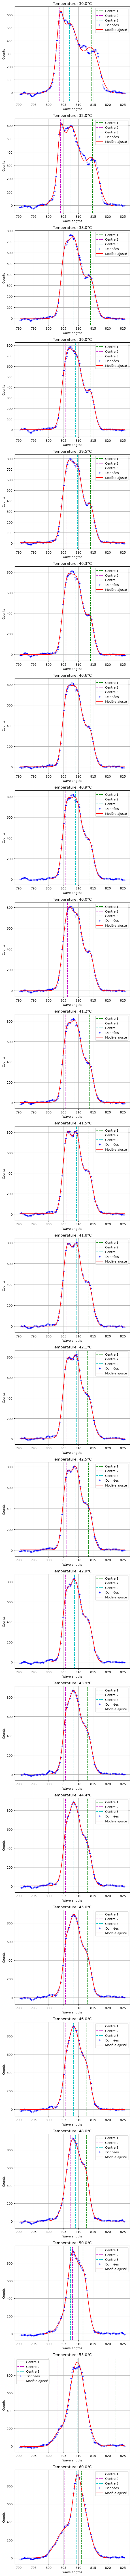

In [92]:
#Fit et affichage du fit sur tous les profils

Parametres = []
Temperatures = []

#Selection des données associées à la température
couples_profils_temp = extraction_profils_temperature("Donnees_temperature")

# Créer un figure pour tracer les résultats
fig, axes = plt.subplots(len(couples_profils_temp), 1, figsize=(6, len(couples_profils_temp) * 5))

for i, couple in enumerate(couples_profils_temp):

    valeur_temp = couple[0]

    x_data, y_data = couple[1]

    y_data = y_data - photons_bleu
    
    couple = (valeur_temp,[x_data, y_data])
    
    try:
        # Tenter le fit avec fit_triple_gaussienne
        popt = fit_triple_gaussienne(couple)
        Parametres.append(popt)
        Temperatures.append(valeur_temp)
        y_modele = gaussians(x_data, *popt)  # Générer le modèle avec les paramètres ajustés

        # Tracer les lignes verticales pour les centres des gaussiennes
        axes[i].axvline(popt[1], color='g', linestyle='--', label='Centre 1')  # Centre de la 1ère gaussienne
        axes[i].axvline(popt[4], color='m', linestyle='--', label='Centre 2')  # Centre de la 2ème gaussienne
        axes[i].axvline(popt[7], color='c', linestyle='--', label='Centre 3')  # Centre de la 3ème gaussienne
        
        # Tracer les données et le modèle ajusté
        axes[i].plot(x_data, y_data, 'b+', label='Données')  # Données expérimentales
        axes[i].plot(x_data, y_modele, 'r-', label='Modèle ajusté')  # Modèle ajusté
        axes[i].set_title(f'Temperature: {valeur_temp}°C')  # Ajouter la température dans le titre
        axes[i].set_xlabel('Wavelengths')
        axes[i].set_ylabel('Counts')
        axes[i].grid(True)
        axes[i].legend()

    except RuntimeError:
        # Gestion des erreurs si le fit ne converge pas
        print(f"Le fit n'a pas convergé pour la température {valeur_temp}°C.")
        axes[i].plot(x_data, y_data, 'b+', label='Données')  # Afficher uniquement les données
        axes[i].set_title(f'Temperature: {valeur_temp}°C (fit échoué)')  # Indiquer que le fit a échoué
        axes[i].set_xlabel('Wavelengths')
        axes[i].set_ylabel('Counts')
        axes[i].grid(True)
        axes[i].legend()

# Ajuster les espacements entre les subplots
plt.tight_layout()
plt.show()

Le fit n'a pas convergé pour la température 39.0°C.
Le fit n'a pas convergé pour la température 40.0°C.
Le fit n'a pas convergé pour la température 41.2°C.
Le fit n'a pas convergé pour la température 41.5°C.
Le fit n'a pas convergé pour la température 41.8°C.
Le fit n'a pas convergé pour la température 42.1°C.
Le fit n'a pas convergé pour la température 42.5°C.
Le fit n'a pas convergé pour la température 44.4°C.
Le fit n'a pas convergé pour la température 46.0°C.
Le fit n'a pas convergé pour la température 50.0°C.


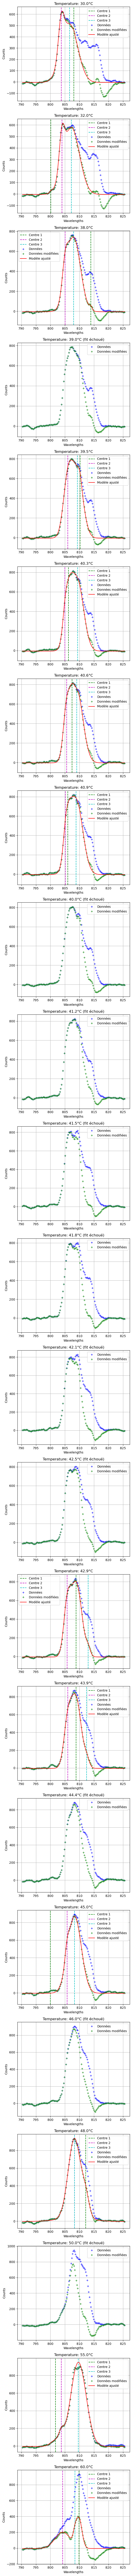

In [97]:
#Fit d'un profil des données avec un modèle de double gaussiennes dont les paramètres et l'intervalle de recherche sont fixés

# Définir le modèle de fit
def double_gaussians(x, I1, t1, s1, I2, t2, s2, bckg):
    gauss1 = I1 * np.exp(-(x - t1)**2 / s1**2)
    gauss2 = I2 * np.exp(-(x - t2)**2 / s2**2)
    return gauss1 + gauss2 + bckg

def fit_double_gaussienne(couple):

    # Paramètres de fit
    lower_bound = [0, 802, 0,
                   0, 802, 0,
                   -5]
    
    upper_bound = [np.inf, 817, np.inf,
                   np.inf, 817, np.inf,
                   10]
    
    initial_guess = [600, 807, 5,
                     600, 808, 5,
                     0]
    
    valeur_temp, couple_profil = couple[0], couple[1]
    
    x_data, y_data = couple_profil[0], couple_profil[1]
    
    # Fit des données
    popt, pcov = curve_fit(double_gaussians, x_data, y_data, p0=initial_guess, bounds=(lower_bound, upper_bound))

    return(popt)

def gaussienne(x, amplitude, mean, std_dev):

    return amplitude * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

#Fit modifié et affichage du fit sur tous les profils

#Fit modifié: la troisième gaussienne déterminée par le premier fit est soustraite au jeu de données. Un nouveau fit est réalisé sur le jeu de données modifié

Parametres_modif = []
Temperatures = []

#Selection des données associées à la température
couples_profils_temp = extraction_profils_temperature("Donnees_temperature")

# Créer un figure pour tracer les résultats
fig, axes = plt.subplots(len(couples_profils_temp), 1, figsize=(6, len(couples_profils_temp) * 5))

for i, couple in enumerate(couples_profils_temp):

    valeur_temp = couple[0]

    x_data, y_data = couple[1]

    y_data = y_data - photons_bleu

    couple = (valeur_temp,[x_data, y_data])
    
    try:
        # Tenter le fit avec fit_triple_gaussienne
        popt = fit_triple_gaussienne(couple)

        params_troisieme_gaussienne = np.copy(popt)[:3]
        
        y_troisieme_gaussienne = gaussienne(x_data, *params_troisieme_gaussienne)  # Générer le modèle avec les paramètres ajustés

        y_data_modifie = y_data - y_troisieme_gaussienne

        couple_modifie = [valeur_temp,[x_data, y_data_modifie]]

        try:
            
            popt_nouveaux = fit_triple_gaussienne(couple_modifie)
    
            y_modele_modifie = gaussians(x_data, *popt_nouveaux)  # Générer le modèle avec les paramètres ajustés
    
            Parametres_modif.append(popt_nouveaux)
            Temperatures.append(valeur_temp)
    
            # Tracer les lignes verticales pour les centres des gaussiennes
            axes[i].axvline(popt_nouveaux[1], color='g', linestyle='--', label='Centre 1')  # Centre de la 1ère gaussienne
            axes[i].axvline(popt_nouveaux[4], color='m', linestyle='--', label='Centre 2')  # Centre de la 2ème gaussienne
            axes[i].axvline(popt_nouveaux[7], color='c', linestyle='--', label='Centre 3')  # Centre de la 3ème gaussienne
            
            # Tracer les données et le modèle ajusté
            axes[i].plot(x_data, y_data, 'b+', label='Données')  # Données expérimentales
            axes[i].plot(x_data, y_data_modifie, 'g+', label='Données modifiées')  # Données expérimentales modifiées
            axes[i].plot(x_data, y_modele_modifie, 'r-', label='Modèle ajusté')  # Modèle ajusté
            axes[i].set_title(f'Temperature: {valeur_temp}°C')  # Ajouter la température dans le titre
            axes[i].set_xlabel('Wavelengths')
            axes[i].set_ylabel('Counts')
            axes[i].grid(True)
            axes[i].legend()

        except RuntimeError:
            # Gestion des erreurs si le fit ne converge pas
            print(f"Le fit n'a pas convergé pour la température {valeur_temp}°C.")
            axes[i].plot(x_data, y_data, 'b+', label='Données')  # Afficher uniquement les données
            axes[i].plot(x_data, y_data_modifie, 'g+', label='Données modifiées')  # Données expérimentales modifiées
            axes[i].set_title(f'Temperature: {valeur_temp}°C (fit échoué)')  # Indiquer que le fit a échoué
            axes[i].set_xlabel('Wavelengths')
            axes[i].set_ylabel('Counts')
            axes[i].grid(True)
            axes[i].legend()

    except RuntimeError:
        # Gestion des erreurs si le fit ne converge pas
        print(f"Le fit n'a pas convergé pour la température {valeur_temp}°C.")
        axes[i].plot(x_data, y_data, 'b+', label='Données')  # Afficher uniquement les données
        axes[i].set_title(f'Temperature: {valeur_temp}°C (fit échoué)')  # Indiquer que le fit a échoué
        axes[i].set_xlabel('Wavelengths')
        axes[i].set_ylabel('Counts')
        axes[i].grid(True)
        axes[i].legend()

# Ajuster les espacements entre les subplots
plt.tight_layout()
plt.show()

Le fit n'a pas convergé pour la température 42.9°C.
Le fit n'a pas convergé pour la température 43.9°C.
Le fit n'a pas convergé pour la température 44.4°C.
Le fit n'a pas convergé pour la température 45.0°C.
Le fit n'a pas convergé pour la température 46.0°C.
Le fit n'a pas convergé pour la température 48.0°C.


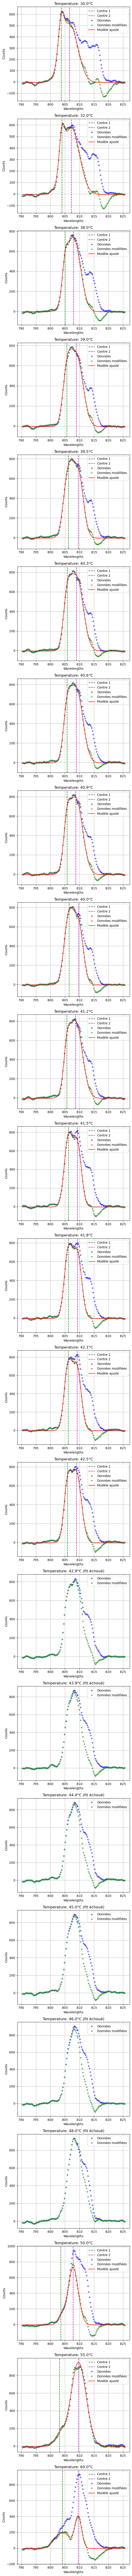

In [115]:
#Fit d'un profil des données avec un modèle de double gaussiennes dont les paramètres et l'intervalle de recherche sont fixés

# Définir le modèle de fit
def double_gaussians(x, I1, t1, s1, I2, t2, s2, bckg):
    gauss1 = I1 * np.exp(-(x - t1)**2 / s1**2)
    gauss2 = I2 * np.exp(-(x - t2)**2 / s2**2)
    return gauss1 + gauss2 + bckg

def fit_double_gaussienne(couple):

    # Paramètres de fit
    lower_bound = [0, 802, 0,
                   0, 802, 0,
                   -5]
    
    upper_bound = [np.inf, 817, np.inf,
                   np.inf, 817, np.inf,
                   10]
    
    initial_guess = [600, 807, 5,
                     600, 808, 5,
                     0]
    
    valeur_temp, couple_profil = couple[0], couple[1]
    
    x_data, y_data = couple_profil[0], couple_profil[1]
    
    # Fit des données
    popt, pcov = curve_fit(double_gaussians, x_data, y_data, p0=initial_guess, bounds=(lower_bound, upper_bound))

    return(popt)

def gaussienne(x, amplitude, mean, std_dev):

    return amplitude * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

#Fit modifié et affichage du fit sur tous les profils

#Fit modifié: la troisième gaussienne déterminée par le premier fit est soustraite au jeu de données. Un nouveau fit est réalisé sur le jeu de données modifié

Parametres_modifie = []
Temperatures = []
indices_echec = []

#Selection des données associées à la température
couples_profils_temp = extraction_profils_temperature("Donnees_temperature")

# Créer un figure pour tracer les résultats
fig, axes = plt.subplots(len(couples_profils_temp), 1, figsize=(6, len(couples_profils_temp) * 5))

for i, couple in enumerate(couples_profils_temp):

    valeur_temp = couple[0]

    x_data, y_data = couple[1]

    y_data = y_data - photons_bleu

    couple = (valeur_temp,[x_data, y_data])
    
    try:
        # Tenter le fit avec fit_triple_gaussienne
        popt = fit_triple_gaussienne(couple)

        params_troisieme_gaussienne = np.copy(popt)[:3]
        
        y_troisieme_gaussienne = gaussienne(x_data, *params_troisieme_gaussienne)  # Générer le modèle avec les paramètres ajustés

        y_data_modifie = y_data - y_troisieme_gaussienne

        couple_modifie = [valeur_temp,[x_data, y_data_modifie]]

        Temperatures.append(valeur_temp)

        try:
            # Tenter le fit avec fit_double_gaussienne
            popt_nouveaux = fit_double_gaussienne(couple_modifie)
    
            y_modele_modifie = double_gaussians(x_data, *popt_nouveaux)  # Générer le modèle avec les paramètres ajustés
    
            Parametres_modifie.append(popt_nouveaux)
    
            # Tracer les lignes verticales pour les centres des gaussiennes
            axes[i].axvline(popt_nouveaux[1], color='g', linestyle='--', label='Centre 1')  # Centre de la 1ère gaussienne
            axes[i].axvline(popt_nouveaux[4], color='m', linestyle='--', label='Centre 2')  # Centre de la 2ème gaussienne
            
            # Tracer les données et le modèle ajusté
            axes[i].plot(x_data, y_data, 'b+', label='Données')  # Données expérimentales
            axes[i].plot(x_data, y_data_modifie, 'g+', label='Données modifiées')  # Données expérimentales modifiées
            axes[i].plot(x_data, y_modele_modifie, 'r-', label='Modèle ajusté')  # Modèle ajusté
            axes[i].set_title(f'Temperature: {valeur_temp}°C')  # Ajouter la température dans le titre
            axes[i].set_xlabel('Wavelengths')
            axes[i].set_ylabel('Counts')
            axes[i].grid(True)
            axes[i].legend()

        except RuntimeError:
            indices_echec.append(i)
            
            # Gestion des erreurs si le fit ne converge pas
            print(f"Le fit n'a pas convergé pour la température {valeur_temp}°C.")
            axes[i].plot(x_data, y_data, 'b+', label='Données')  # Afficher uniquement les données
            axes[i].plot(x_data, y_data_modifie, 'g+', label='Données modifiées')  # Données expérimentales modifiées
            axes[i].set_title(f'Temperature: {valeur_temp}°C (fit échoué)')  # Indiquer que le fit a échoué
            axes[i].set_xlabel('Wavelengths')
            axes[i].set_ylabel('Counts')
            axes[i].grid(True)
            axes[i].legend()

    except RuntimeError:
        # Gestion des erreurs si le fit ne converge pas
        print(f"Le fit n'a pas convergé pour la température {valeur_temp}°C.")
        axes[i].plot(x_data, y_data, 'b+', label='Données')  # Afficher uniquement les données
        axes[i].set_title(f'Temperature: {valeur_temp}°C (fit échoué)')  # Indiquer que le fit a échoué
        axes[i].set_xlabel('Wavelengths')
        axes[i].set_ylabel('Counts')
        axes[i].grid(True)
        axes[i].legend()

# Ajuster les espacements entre les subplots
plt.tight_layout()
plt.show()

23 23
17 17


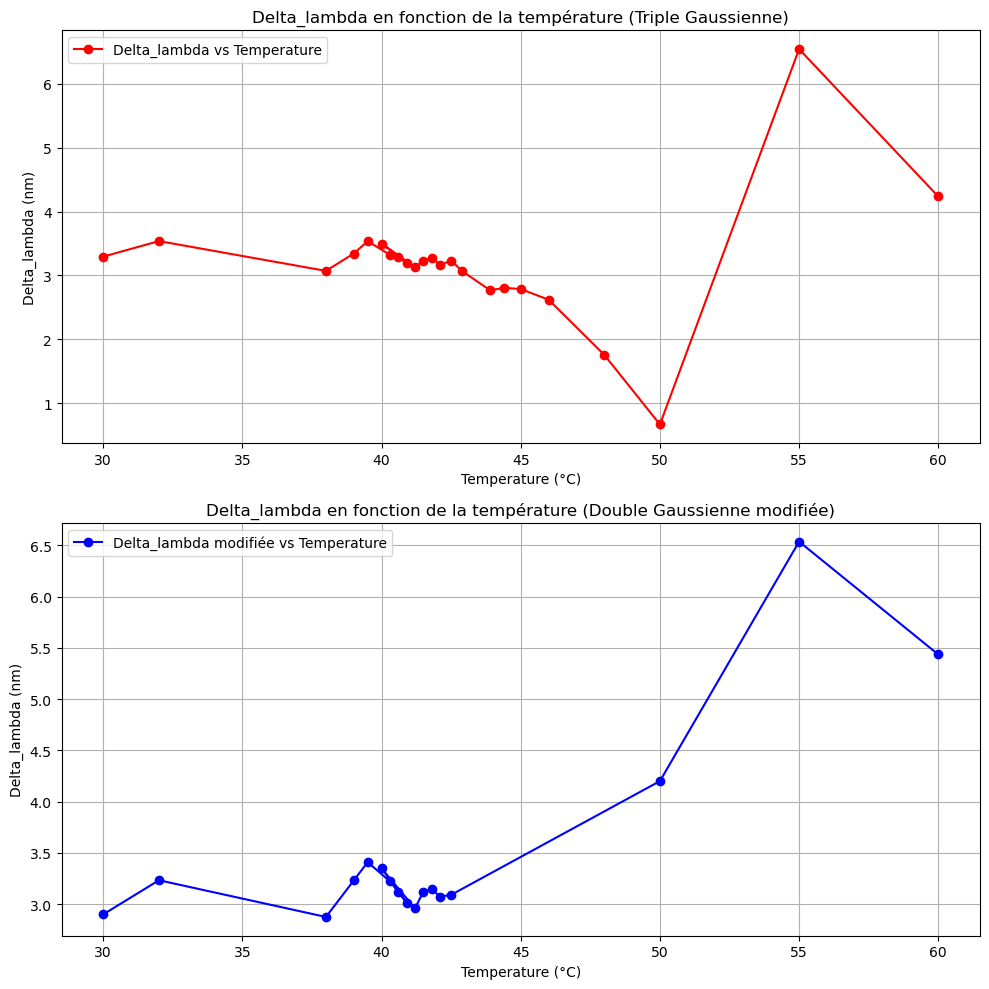

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# Exemple de données pour Parametres, Parametres_modifie, Temperatures, indices_echec
# Parametres, Parametres_modifie, Temperatures, indices_echec doivent être définis dans votre code

# Crée une figure avec deux sous-graphiques verticaux
plt.figure(figsize=(10, 10))

# Tracé 1 : Delta_lambda vs Temperature (fit triple gaussienne simple)
plt.subplot(2, 1, 1)  # Première ligne du subplot
Delta_lambda = [np.abs(params[7] - params[4]) for params in Parametres]

print(len(Temperatures), len(Delta_lambda))

plt.plot(Temperatures, Delta_lambda, 'ro-', label='Delta_lambda vs Temperature')  # 'ro-' pour des points rouges et lignes
plt.xlabel('Temperature (°C)')
plt.ylabel('Delta_lambda (nm)')
plt.title('Delta_lambda en fonction de la température (Triple Gaussienne)')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Tracé 2 : Delta_lambda vs Temperature (fit double gaussienne sur données modifiées)
plt.subplot(2, 1, 2)  # Deuxième ligne du subplot
Delta_lambda_modifie = [np.abs(params_modifie[4] - params_modifie[1]) for params_modifie in Parametres_modifie]

# Supprimer les éléments aux indices d'échec
indices_echec_set = set(indices_echec)
Temperatures_modifie = [elem for i, elem in enumerate(Temperatures) if i not in indices_echec_set]

print(len(Temperatures_modifie), len(Delta_lambda_modifie))

plt.plot(Temperatures_modifie, Delta_lambda_modifie, 'bo-', label='Delta_lambda modifiée vs Temperature')  # 'bo-' pour des points bleus et lignes
plt.xlabel('Temperature (°C)')
plt.ylabel('Delta_lambda (nm)')
plt.title('Delta_lambda en fonction de la température (Double Gaussienne modifiée)')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Afficher la figure avec les deux sous-graphiques
plt.show()


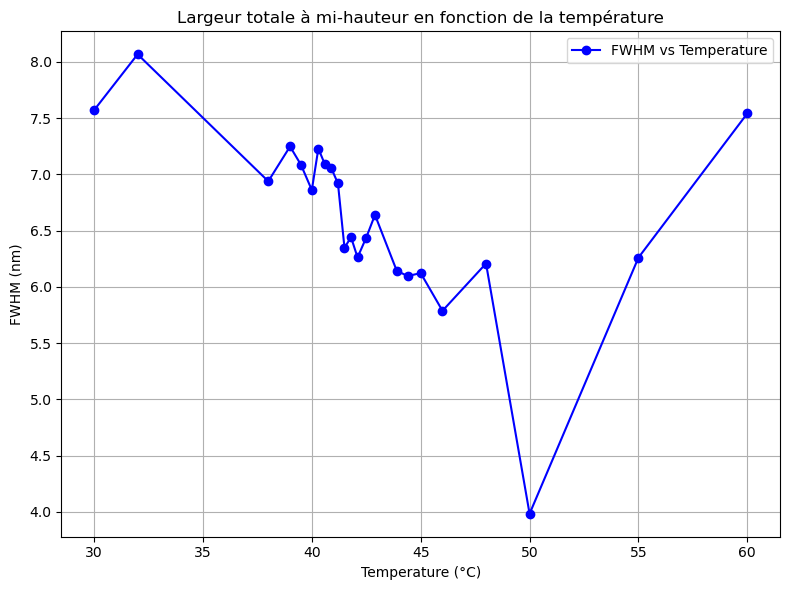

In [73]:
def calcul_fwhm(x, y):
    """
    Calcule la largeur totale à mi-hauteur (FWHM) pour une fonction quelconque donnée par ses points x et y.

    Args:
        x (array-like): Les abscisses (points de l'axe des x).
        y (array-like): Les ordonnées (valeurs de la fonction à chaque x).

    Returns:
        float: La largeur totale à mi-hauteur (FWHM).
    """
    # Trouver la hauteur maximale du pic
    max_height = max(y)
    half_max = max_height / 2  # Mi-hauteur

    # Trouver les indices où y croise ou dépasse la mi-hauteur
    indices_above_half = np.where(y >= half_max)[0]

    if len(indices_above_half) < 2:
        print("Impossible de calculer la FWHM : la fonction n'a pas deux croisements avec la mi-hauteur.")
        return None

    # Les indices du début et de la fin du croisement avec la mi-hauteur
    left_index = indices_above_half[0]
    right_index = indices_above_half[-1]

    # Calculer les abscisses correspondantes
    x_left = x[left_index]
    x_right = x[right_index]

    # Largeur totale à mi-hauteur
    fwhm = x_right - x_left
    return fwhm

# Liste des FWHM pour chaque fonction décrite par les paramètres de Parametres
FWHM_list = []

for params in Parametres:
    params_sans_troisieme_gaussienne = np.copy(params)
    params_sans_troisieme_gaussienne[0] = 0
    # Générer les données de x et y pour chaque ensemble de paramètres
    x = np.linspace(800, 815, 10000)  # Exemple de plage des longueurs d'onde
    y = gaussians(x, *params_sans_troisieme_gaussienne)  # Calcul des ordonnées avec les paramètres

    # Calculer la FWHM pour cette fonction
    fwhm = calcul_fwhm(x, y)
    FWHM_list.append(fwhm)

# Tri et réarrangement
sorted_pairs = sorted(zip(Temperatures, FWHM_list))  # Associe A et B, puis trie par A
Temperatures_sorted, FWHM_list_sorted = zip(*sorted_pairs)  # Décompresse les paires triées

Temperatures_sorted = list(Temperatures_sorted)
FWHM_list_sorted = list(FWHM_list_sorted)

# Tracé des FWHM en fonction des températures
plt.figure(figsize=(8, 6))
plt.plot(Temperatures_sorted, FWHM_list_sorted, 'bo-', label='FWHM vs Temperature')  # 'bo-' pour des points bleus et lignes
plt.xlabel('Temperature (°C)')
plt.ylabel('FWHM (nm)')
plt.title('Largeur totale à mi-hauteur en fonction de la température')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Etude de l'angle de la $\frac{\lambda}{2}$

In [55]:
def extraire_angle(chaine):
    """
    Extrait l'angle à partir d'une chaîne contenant un format 'xxdeg' ou 'xx.xxdeg'.

    Args:
        chaine (str): Chaîne à analyser.

    Returns:
        float: L'angle extrait.
    """
    # Expression régulière pour extraire un entier ou un float suivi de 'deg'
    match = re.search(r"(\d+(?:\.\d{1,2})?)deg", chaine)

    # Vérification si la correspondance a été trouvée
    if match:
        return float(match.group(1))  # Convertir la chaîne capturée en float
    else:
        print(f"Aucun angle trouvé dans la chaîne : {chaine}")
        return None  # Retourner None si aucune correspondance n'est trouvée

def extraction_profils_angle(folder_name):
    """
    Extrait les profils et les angles à partir des fichiers dans un dossier donné.

    Args:
        folder_name (str): Chemin du dossier contenant les fichiers.

    Returns:
        list: Une liste de couples [angle, couple_profil], où angle est un float 
              et couple_profil contient les données du profil.
    """
    couples_profils = []
    
    for nom_fichier in os.listdir(folder_name):
        # Filtrer les fichiers non pertinents
        if nom_fichier.startswith('.') or 'checkpoints' in nom_fichier:
            continue
        
        chemin_fichier = os.path.join(folder_name, nom_fichier)
        
        # Assurez-vous que c'est un fichier valide
        if not os.path.isfile(chemin_fichier):
            continue

        # Extraire l'angle à partir du nom du fichier
        valeur_angle = extraire_angle(nom_fichier)
        
        if valeur_angle is not None:  # Si un angle valide est trouvé
            couple_profil = extraction_valeurs(chemin_fichier)
            couples_profils.append([valeur_angle, couple_profil])

    return couples_profils

In [56]:
couples_profils_angle = extraction_profils_angle("Donnees_angle")

# Trier la liste par les valeurs croissantes de l'angle
couples_profils_angle_trie = sorted(couples_profils_angle, key=lambda couple: couple[0])

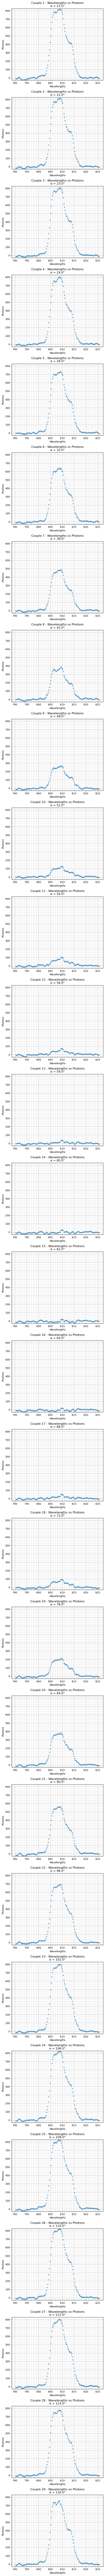

In [57]:
# Calculer les limites globales pour l'échelle verticale
min_photons = float('inf')
max_photons = float('-inf')

for couple in couples_profils_angle_trie:
    wavelengths, photons = couple[1]
    photons = photons - photons_bleu
    min_photons = min(min_photons, np.min(photons))
    max_photons = max(max_photons, np.max(photons))

# Créer les subplots
fig, axes = plt.subplots(len(couples_profils_angle_trie), 1, figsize=(6, len(couples_profils_angle_trie) * 5))

# Tracer chaque couple dans un subplot
for i, couple in enumerate(couples_profils_angle_trie):
    valeur_angle, couple_profil = couple[0], couple[1]
    
    wavelengths, photons = couple_profil[0], couple_profil[1]
    photons = photons - photons_bleu

    # Tracer le scatter plot dans l'axe i
    axes[i].plot(wavelengths, photons, "+", linewidth=0.5)
    axes[i].set_title(f'Couple {i+1} : Wavelengths vs Photons\nα = {valeur_angle}°')
    axes[i].set_xlabel('Wavelengths')
    axes[i].set_ylabel('Photons')
    axes[i].grid(True)  # Activer la grille principale
    
    # Ajout de la sous-grille
    axes[i].minorticks_on()  # Activer les ticks mineurs
    axes[i].grid(which='minor', linestyle=':', linewidth=0.5, color='gray')  # Sous-grille (grille mineure)
    
    # Appliquer les mêmes limites verticales
    axes[i].set_ylim(min_photons, max_photons)

# Ajuster les espacements entre les subplots
plt.tight_layout()
plt.show()

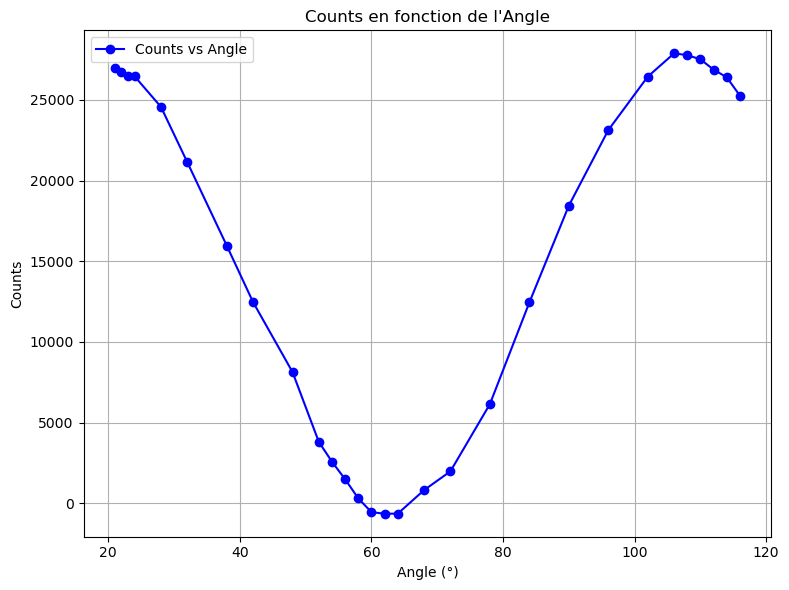

In [58]:
# Initialiser les listes pour les counts et les angles
Counts_list = []
Angles_list = []

# Parcours de chaque couple trié par angle
for couple in couples_profils_angle_trie:
    
    valeur_angle, couple_profil = couple[0], couple[1]
    
    # Extraction des longueurs d'onde (wavelengths) et des photons (intensité)
    wavelengths, photons = couple_profil[0], couple_profil[1]
    
    # Ajuster les photons en fonction de photons_bleu
    photons = photons - photons_bleu

    # Calculer la somme des photons (Counts)
    Counts = photons.sum()

    # Ajouter les valeurs dans les listes correspondantes
    Counts_list.append(Counts)
    Angles_list.append(valeur_angle)

# Tracer les counts en fonction de l'angle
plt.figure(figsize=(8, 6))
plt.plot(Angles_list, Counts_list, 'bo-', label='Counts vs Angle')  # 'bo-' pour des points bleus et lignes
plt.xlabel('Angle (°)')
plt.ylabel('Counts')
plt.title('Counts en fonction de l\'Angle')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Etude de la puissance

In [59]:
def extraire_puissance(chaine):
    """
    Extrait la puissance à partir d'une chaîne contenant un format de type 'xxmW' ou 'xx.xmW'.

    Args:
        chaine (str): Chaîne à analyser.

    Returns:
        float: La puissance extraite.
    """
    # Expression régulière pour extraire un entier ou un float suivi de 'mW'
    match = re.search(r"(\d+(?:\.\d{1,2})?)mW", chaine)

    # Vérification si la correspondance a été trouvée
    if match:
        return float(match.group(1))  # Convertir la chaîne capturée en float
    else:
        print(f"Aucune puissance trouvée dans la chaîne : {chaine}")
        return None  # Retourner None si aucune correspondance n'est trouvée

def extraction_profils_puissance(folder_name):
    """
    Extrait les profils et les puissances à partir des fichiers dans un dossier donné.

    Args:
        folder_name (str): Chemin du dossier contenant les fichiers.

    Returns:
        list: Une liste de couples [puissance, couple_profil], où puissance est un float
              et couple_profil contient les données du profil.
    """
    couples_profils = []
    
    for nom_fichier in os.listdir(folder_name):
        # Filtrer les fichiers non pertinents
        if nom_fichier.startswith('.') or 'checkpoints' in nom_fichier:
            continue
        
        chemin_fichier = os.path.join(folder_name, nom_fichier)
        
        # Assurez-vous que c'est un fichier valide
        if not os.path.isfile(chemin_fichier):
            continue

        # Extraire la puissance à partir du nom du fichier
        valeur_puissance = extraire_puissance(nom_fichier)
        
        if valeur_puissance is not None:  # Si une puissance valide est trouvée
            couple_profil = extraction_valeurs(chemin_fichier)
            couples_profils.append([valeur_puissance, couple_profil])

    return couples_profils

In [60]:
couples_profils_puissance = extraction_profils_puissance("Donnees_puissance")

# Trier la liste par les valeurs croissantes de la puissance
couples_profils_puissance_trie = sorted(couples_profils_puissance, key=lambda couple: couple[0])

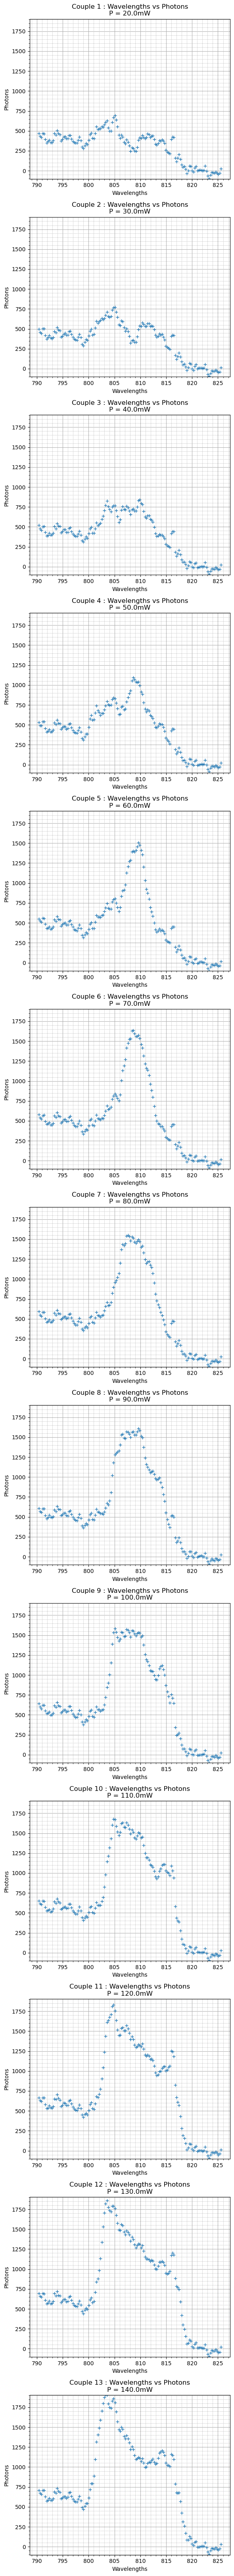

In [61]:
# Calculer les limites globales pour l'échelle verticale
min_photons = float('inf')
max_photons = float('-inf')

for couple in couples_profils_puissance_trie:
    wavelengths, photons = couple[1]
    photons = photons
    min_photons = min(min_photons, np.min(photons))
    max_photons = max(max_photons, np.max(photons))
    
fig, axes = plt.subplots(len(couples_profils_puissance_trie), 1, figsize=(6, len(couples_profils_puissance_trie)*5))

# Pour chaque couple, créer un scatter plot dans le subplot correspondant
for i, couple in enumerate(couples_profils_puissance_trie):

    valeur_puissance, couple_profil = couple[0], couple[1]
    
    wavelengths, photons = couple_profil[0], couple_profil[1]
    
    photons = photons

     # Tracer le scatter plot dans l'axe i
    axes[i].plot(wavelengths, photons, "+", linewidth=0.5)
    axes[i].set_title(f'Couple {i+1} : Wavelengths vs Photons'+"\nP = "+str(valeur_puissance)+"mW")
    axes[i].set_xlabel('Wavelengths')
    axes[i].set_ylabel('Photons')
    axes[i].grid(True)  # Active la grille principale
    
    # Ajout de la sous-grille
    axes[i].minorticks_on()  # Active les "ticks" mineurs
    axes[i].grid(which='minor', linestyle=':', linewidth=0.5, color='gray')  # Sous-grille (grille mineure)

    # Appliquer les mêmes limites verticales
    axes[i].set_ylim(min_photons, max_photons)

# Ajuster les espacements entre les subplots
plt.tight_layout()
plt.show()

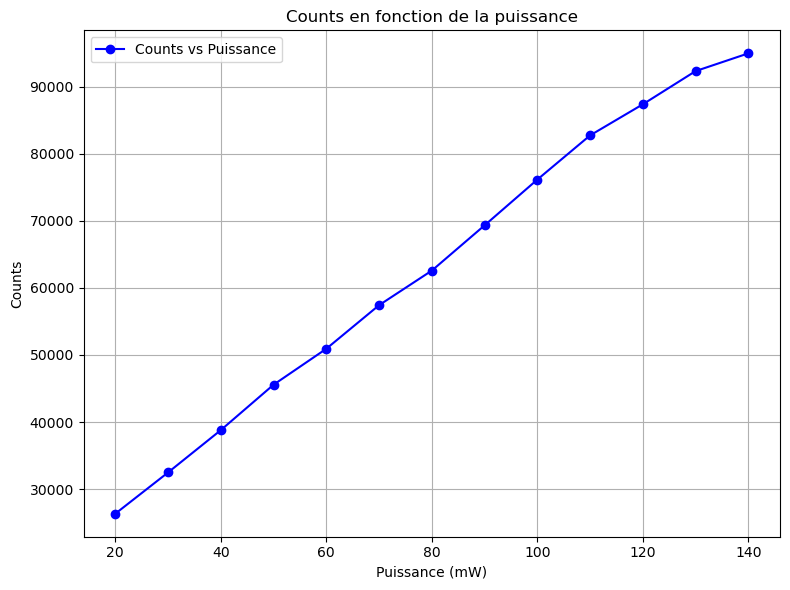

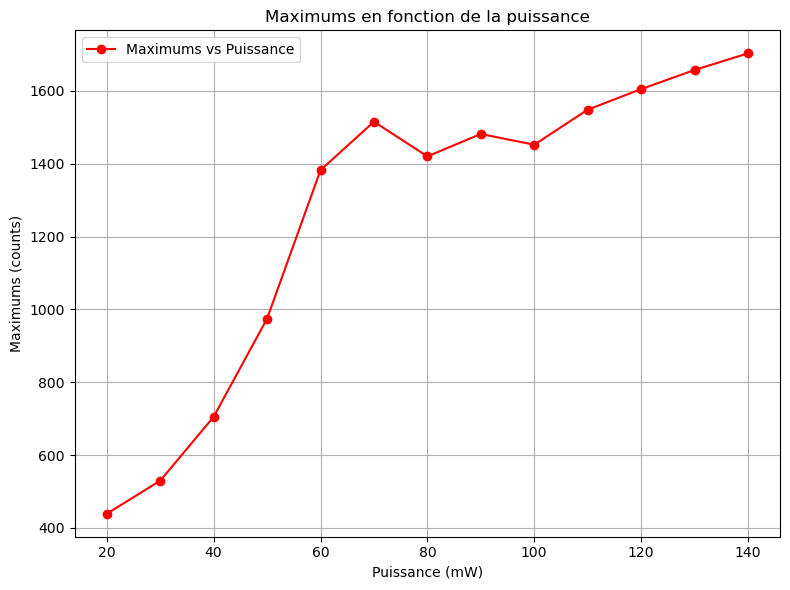

In [62]:
# Initialiser les listes pour les counts, les maximums et les puissances
Counts_list = []
Maximums_list = []
Puissances_list = []

# Parcours de chaque couple trié par puissance
for couple in couples_profils_puissance_trie:
    
    valeur_puissance, couple_profil = couple[0], couple[1]
    
    # Extraction des longueurs d'onde (wavelengths) et des photons (intensité)
    wavelengths, photons = couple_profil[0], couple_profil[1]
    
    # Ajuster les photons en fonction de photons_bleu
    photons = photons - photons_bleu

    # Calculer la somme des photons (Counts) et le maximum
    Counts = photons.sum()
    Maximum = photons.max()

    # Ajouter les valeurs dans les listes correspondantes
    Counts_list.append(Counts)
    Puissances_list.append(valeur_puissance)
    Maximums_list.append(Maximum)

# Tracer les counts en fonction de la puissance
plt.figure(figsize=(8, 6))
plt.plot(Puissances_list, Counts_list, 'bo-', label='Counts vs Puissance')  # 'bo-' pour des points bleus et lignes
plt.xlabel('Puissance (mW)')
plt.ylabel('Counts')
plt.title('Counts en fonction de la puissance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Tracer les maximums en fonction de la puissance
plt.figure(figsize=(8, 6))
plt.plot(Puissances_list, Maximums_list, 'ro-', label='Maximums vs Puissance')  # 'ro-' pour des points rouges et lignes
plt.xlabel('Puissance (mW)')
plt.ylabel('Maximums (counts)')
plt.title('Maximums en fonction de la puissance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

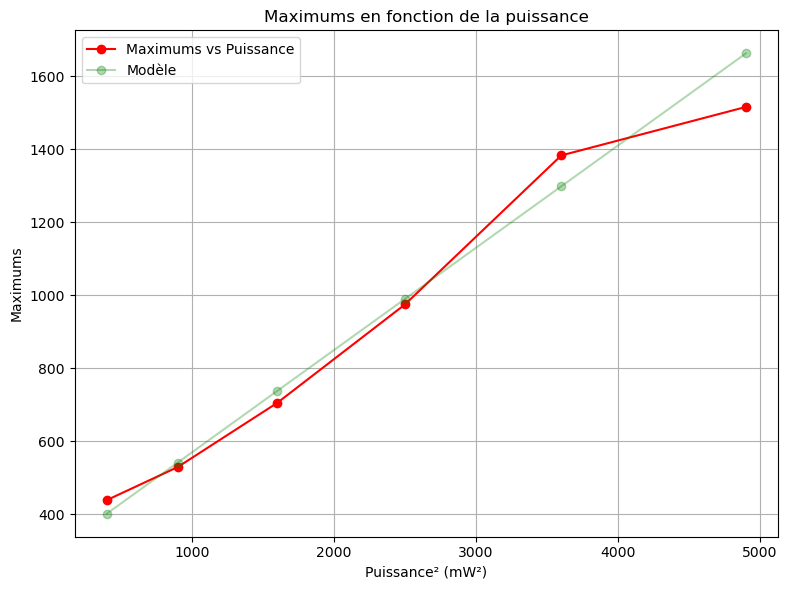

In [63]:
a = 0.28
b = 290

Modele = lambda x: a*x + b

# Tracer les maximums en fonction de la puissance
plt.figure(figsize=(8, 6))
plt.plot(np.array(Puissances_list[:6])**2, Maximums_list[:6], 'ro-', label='Maximums vs Puissance')
plt.plot(np.array(Puissances_list[:6])**2, Modele(np.array(Puissances_list[:6])**2), 'go-', label='Modèle', alpha=0.3)
plt.xlabel('Puissance² (mW²)')
plt.ylabel('Maximums')
plt.title('Maximums en fonction de la puissance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()